In [ ]:
!pip install folium matplotlib mapclassify pmdarima geopandas

In [101]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Locations of 470 sensors

In [103]:
locations = pd.read_csv('/content/drive/MyDrive/traffic predict/traffic_flow_data/locations.csv')

In [104]:
# Create a GeoDataFrame
locations["geometry"] = gpd.points_from_xy(locations["longitude"], locations["latitude"])
# Set coordinate reference system
locations_gdf = gpd.GeoDataFrame(locations, crs="epsg:4326")
# Reproject
locations_gdf = locations_gdf.to_crs("epsg:3857")
locations_gdf

,id,latitude,longitude,geometry
0,GA0151_A,55.863144,-4.275053,POINT (-475896.702 7531219.501)
1,GA0151_C,55.862380,-4.270661,POINT (-475407.832 7531068.01)
2,GA0151_D,55.863617,-4.270334,POINT (-475371.394 7531313.457)
3,GA0401_R,55.863058,-4.269934,POINT (-475326.846 7531202.602)
4,GA0401_S,55.862546,-4.266052,POINT (-474894.767 7531100.912)
...,...,...,...,...
465,GL3551_R,55.851422,-4.318959,POINT (-480784.347 7528894.608)
466,GL3551_S,55.851709,-4.319919,POINT (-480891.19 7528951.618)
467,GL3551_T,55.852724,-4.318510,POINT (-480734.294 7529152.949)
468,GL4151_B,55.865908,-4.339914,POINT (-483116.964 7531768.004)


In [105]:
locations_gdf.explore(color="Red",tiles='cartodbpositron',
                      width=750, height=500)

# Prediction

## 1. SARIMA

### 1.1 Library

In [106]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

### 1.2 Data

In [157]:
df = pd.read_csv('/content/drive/MyDrive/traffic predict/traffic_flow_data/flows/GD030A_S.csv')

### 1.3 Steps

In [150]:
warnings.filterwarnings("ignore")

In [158]:
# Step 1: Preprocess the Data
# Combine 'date' and 'time' into a single datetime index
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].astype(str) + ':00:00')
df.drop(columns=['date', 'time'], inplace=True)

# Generate the full range of timestamps from '2019-10-01' to '2023-09-30'
date_full = pd.date_range(start='2019-10-01 00:00:00', end='2023-09-30 23:00:00', freq='H')
date_full = pd.DataFrame({'datetime': date_full})

traffic_full = pd.merge(date_full, df, on='datetime', how='left')
#traffic_full['flow'] = traffic_full['flow'].astype(dtype='Int64')

# Convert the 'datetime' column to index
traffic_full.set_index('datetime', inplace=True)
# Remove the index title
traffic_full.index.name = None

traffic_full

,flow
2019-10-01 00:00:00,15.0
2019-10-01 01:00:00,9.0
2019-10-01 02:00:00,9.0
2019-10-01 03:00:00,7.0
2019-10-01 04:00:00,9.0
...,...
2023-09-30 19:00:00,129.0
2023-09-30 20:00:00,119.0
2023-09-30 21:00:00,106.0
2023-09-30 22:00:00,88.0


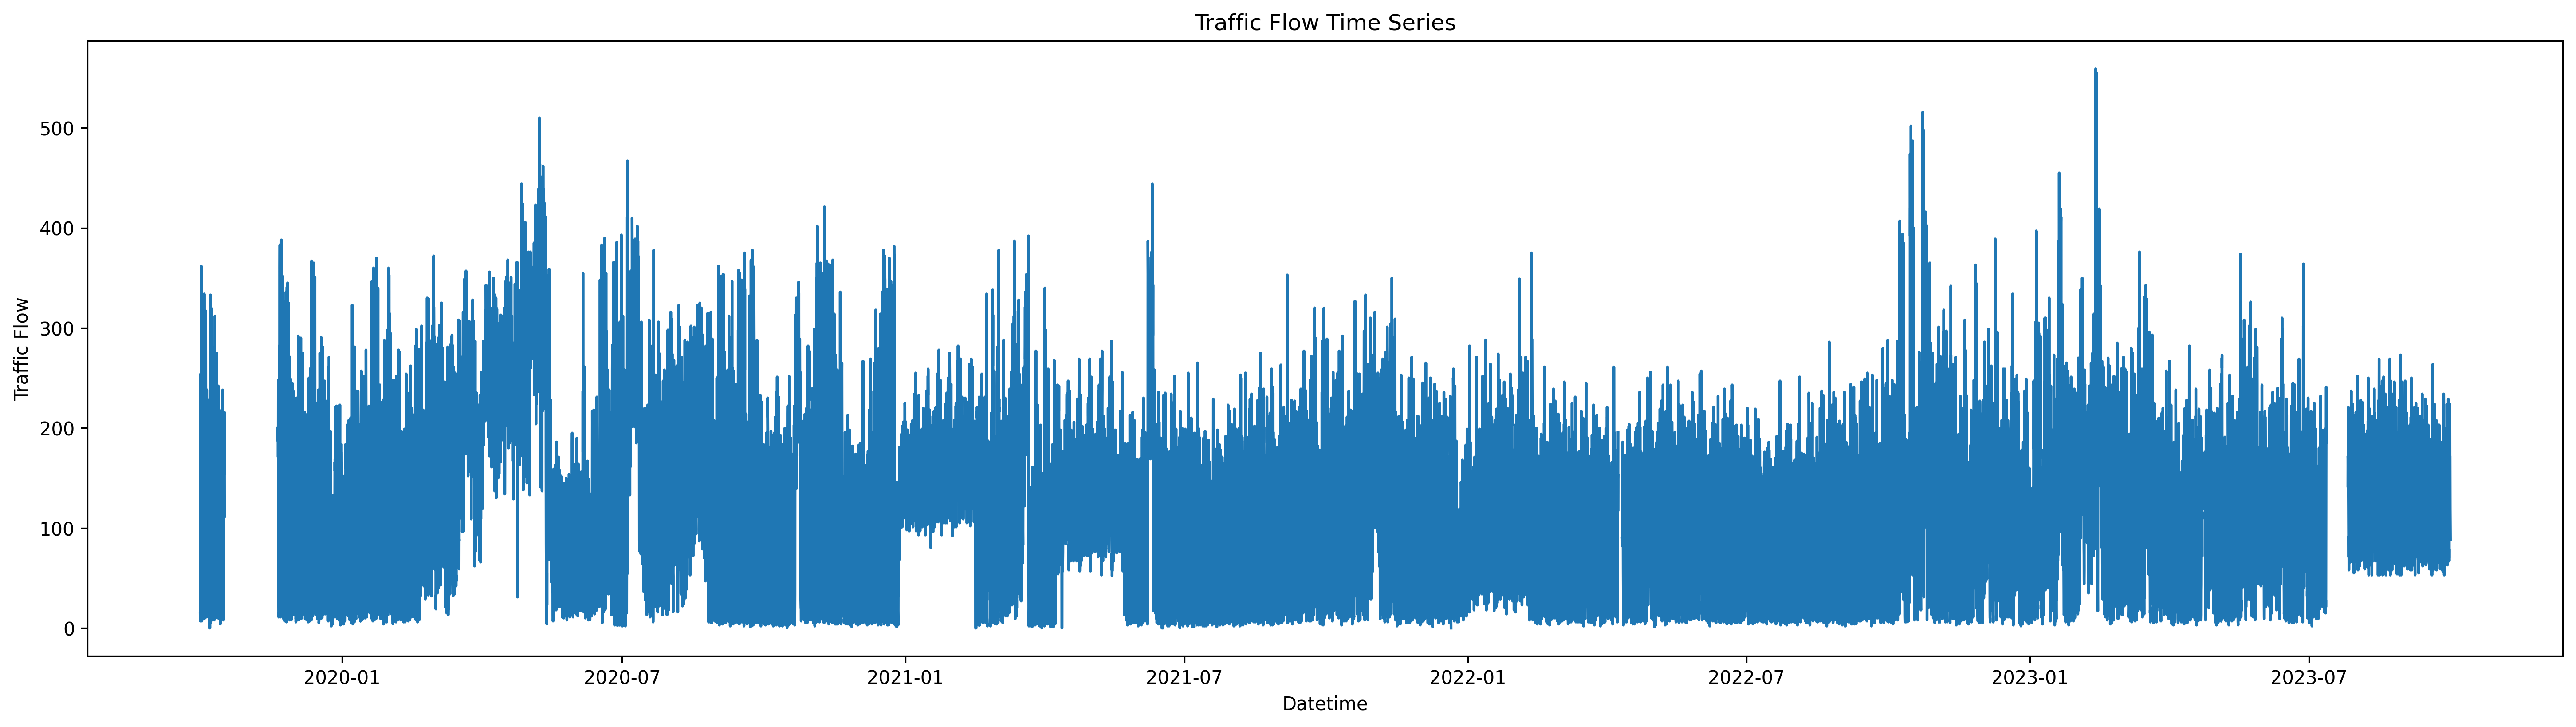

In [159]:
# Step 2: Visualize the Data
plt.figure(figsize=(24, 6),dpi=300)
plt.plot(traffic_full['flow'])
plt.title('Traffic Flow Time Series')
plt.xlabel('Datetime')
plt.ylabel('Traffic Flow')
plt.show()

In [163]:
# Step 3: Check for Stationarity (ADF Test) and differencing
# adfuller can only work for data without nan
result = adfuller(df['flow'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#differencing
d = 0
if result[1] > 0.05:
    traffic_full['flow_diff'] = traffic_full['flow'].diff().dropna()
    data_for_model = traffic_full['flow_diff']
    d = 1
else:
    data_for_model = traffic_full['flow']

ADF Statistic: -10.929660224797791
p-value: 9.896803684002538e-20


Identifying p from PACF:

Look for the point where the PACF plot cuts off (significant spike, followed by spikes close to zero).
If the PACF cuts off sharply after lag k, consider p = k.
Example: If there is a significant spike at lag 1 and no significant spikes afterward, p = 1.



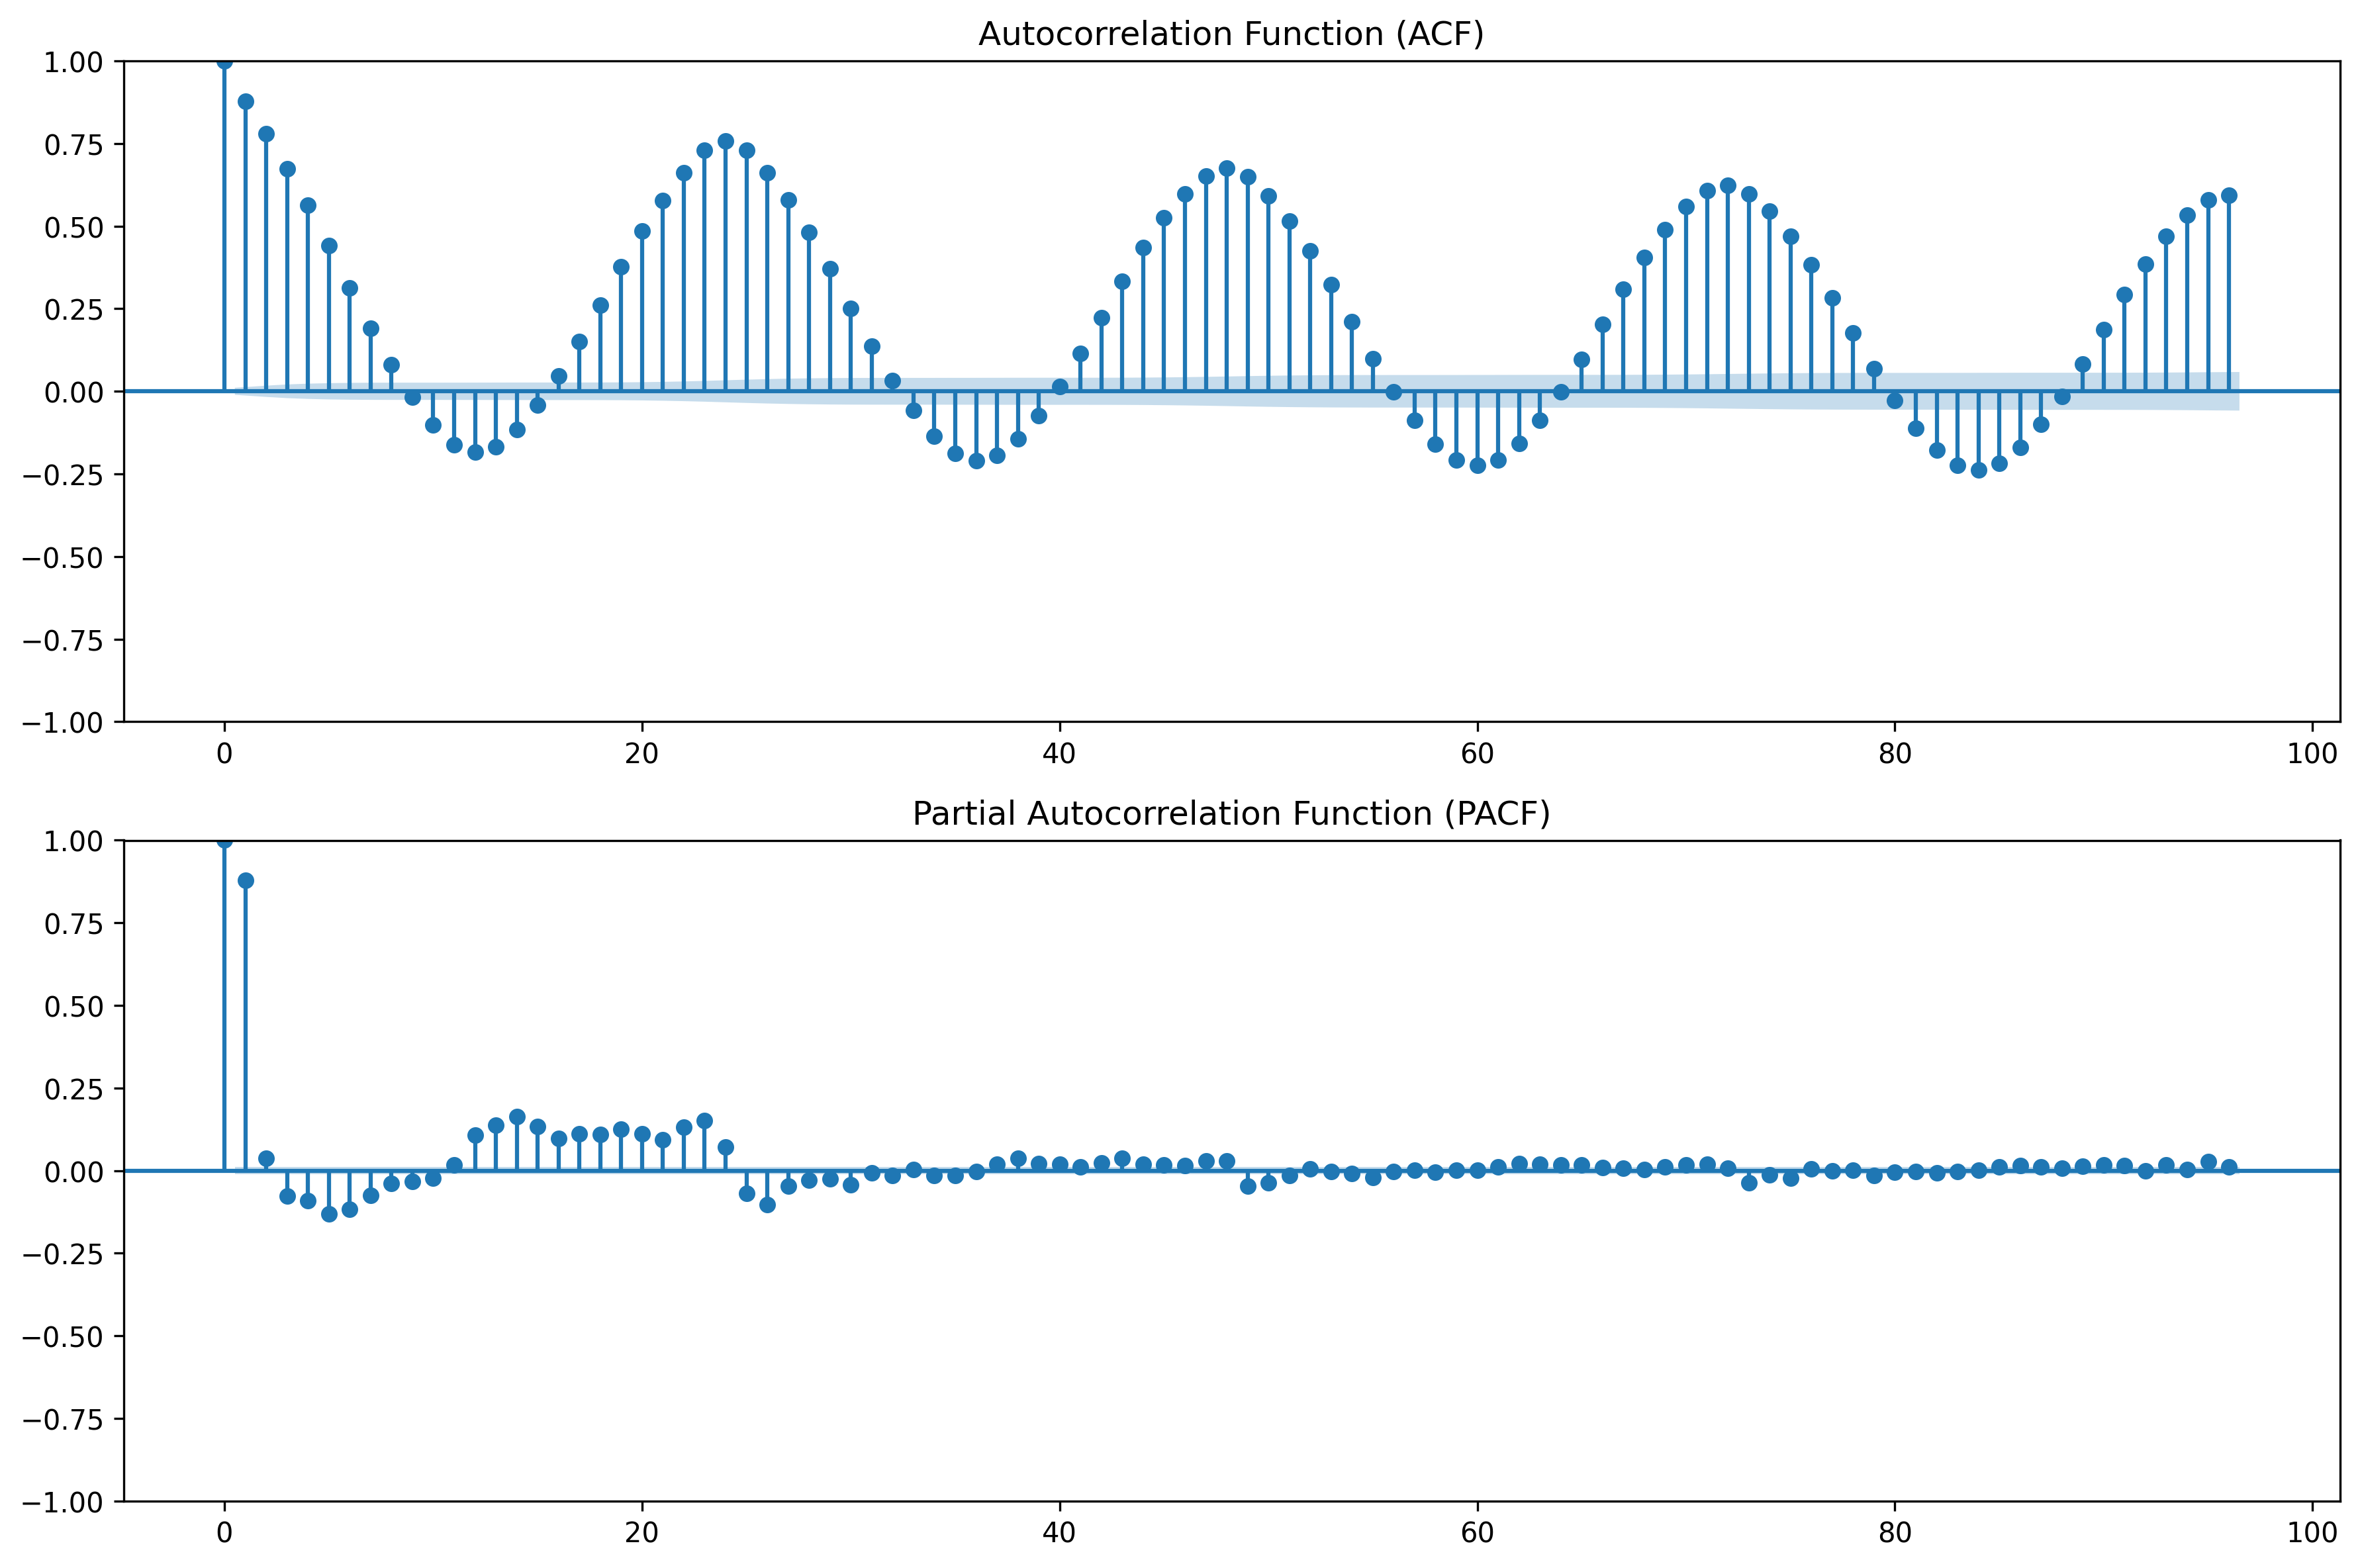

In [164]:
# Step 4: Plot ACF and PACF to Determine p and q
plt.figure(figsize=(12, 8),dpi=300)
plt.subplot(211)
plot_acf(data_for_model.dropna(), ax=plt.gca(), lags=96)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(data_for_model.dropna(), ax=plt.gca(), lags=96)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

ADF Statistic: -27.97388333041873
p-value after seasonal differencing: 0.0
The differenced series is likely stationary.


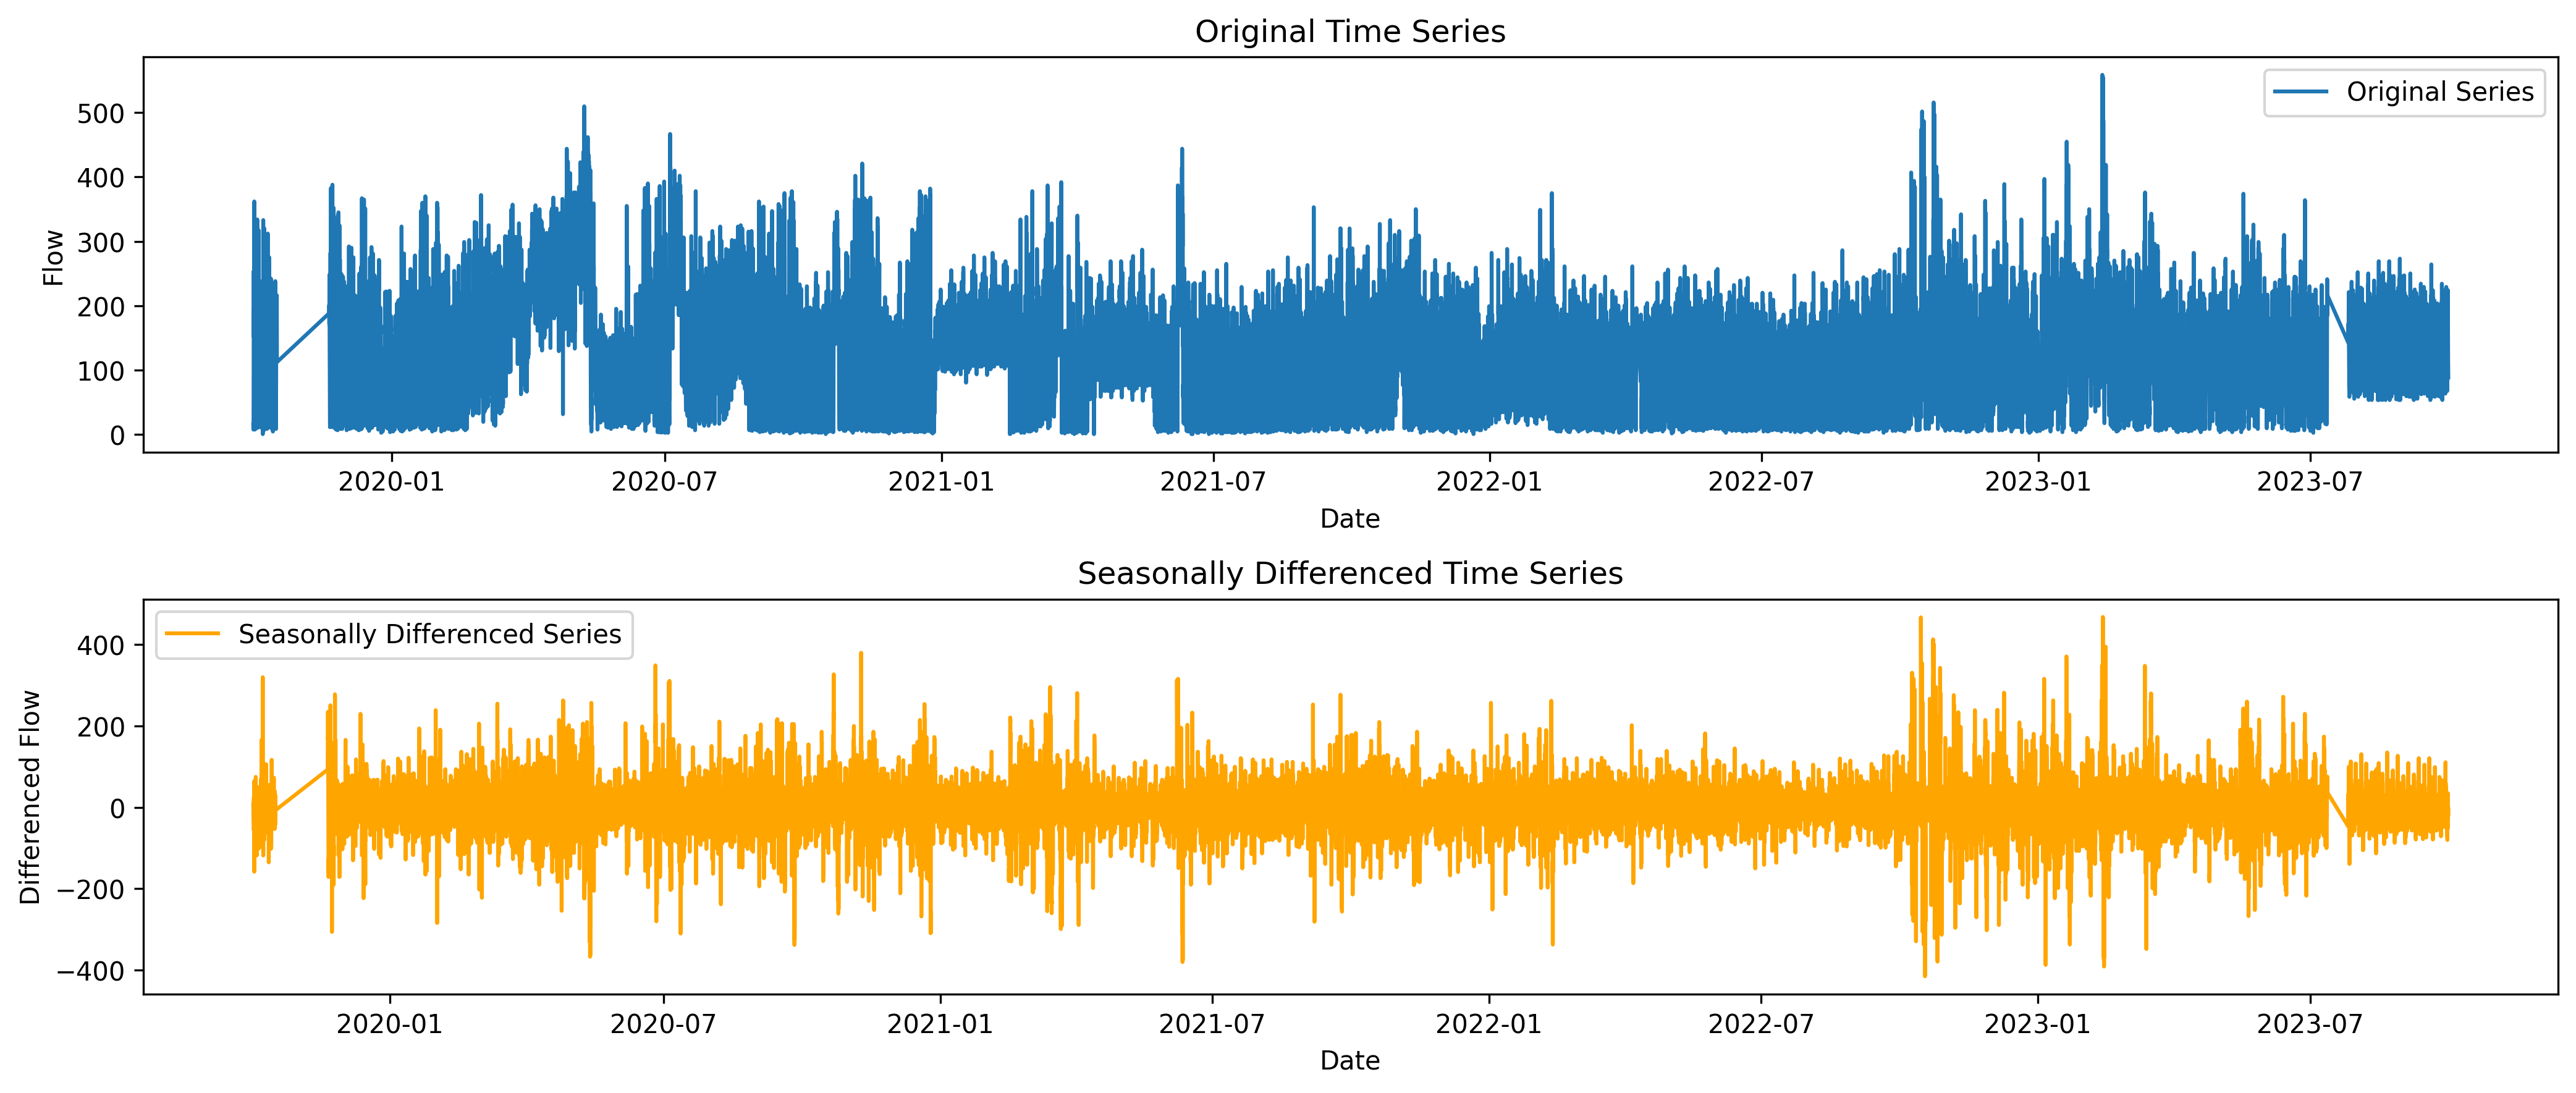

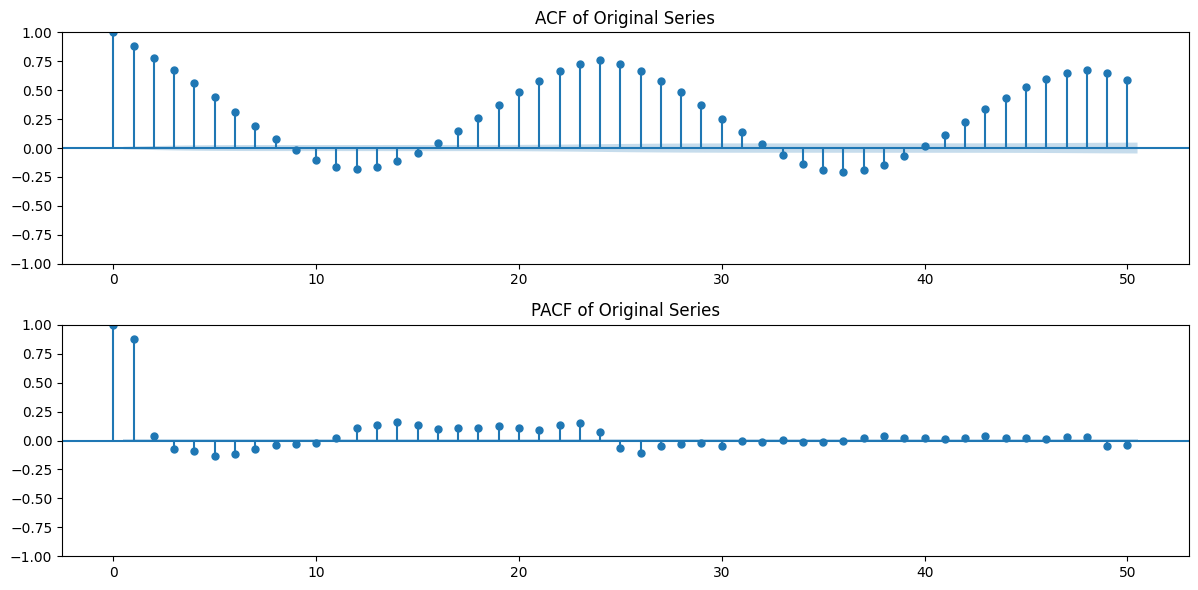

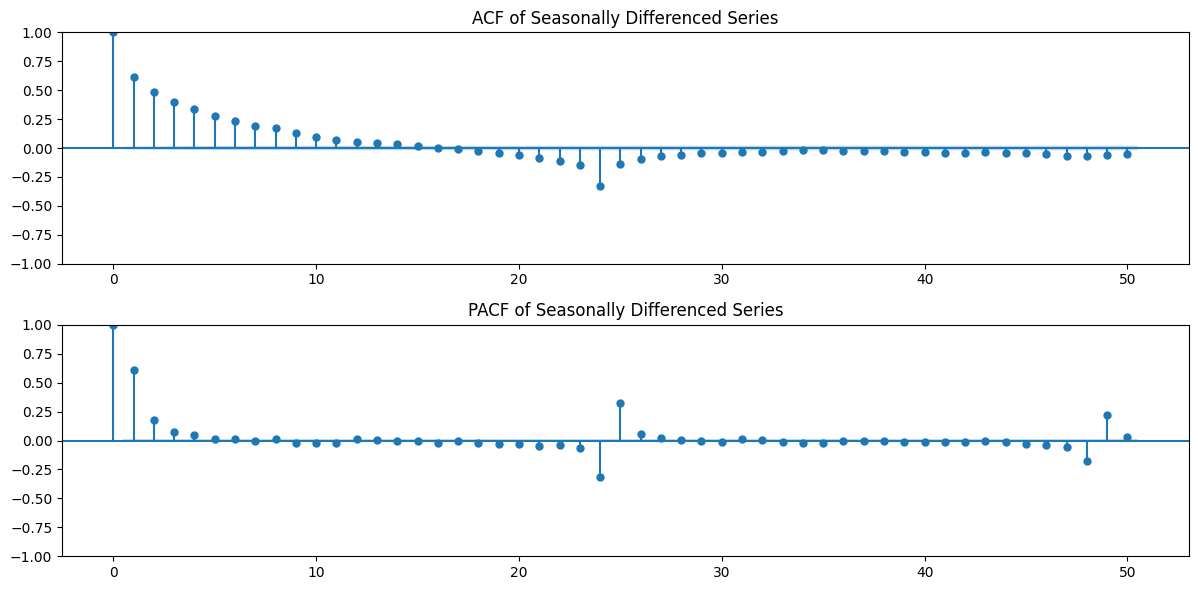

In [ ]:
# Step 5: Check for seasonality
import seaborn as sns

data = df['flow']

# Check for stationarity and seasonal differencing
data_diff = data - data.shift(24)
result = adfuller(data_diff.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value after seasonal differencing: {result[1]}')

if result[1] < 0.05:
    print("The differenced series is likely stationary.")
else:
    print("The differenced series may not be stationary. Further differencing might be needed.")

# Plot the original and seasonally differenced series
plt.figure(figsize=(14, 6), dpi=300)

plt.subplot(2, 1, 1)
plt.plot(data, label='Original Series')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Flow')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_diff, label='Seasonally Differenced Series', color='orange')
plt.title('Seasonally Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Flow')
plt.legend()

plt.tight_layout()
plt.show()


# Plot ACF and PACF
# Plot ACF and PACF for the original series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(data.dropna(), lags=50, ax=plt.gca())
plt.title('ACF of Original Series')

plt.subplot(2, 1, 2)
plot_pacf(data.dropna(), lags=50, ax=plt.gca())
plt.title('PACF of Original Series')

plt.tight_layout()
plt.show()

# Plot ACF and PACF for the seasonally differenced series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(data_diff.dropna(), lags=50, ax=plt.gca())
plt.title('ACF of Seasonally Differenced Series')

plt.subplot(2, 1, 2)
plot_pacf(data_diff.dropna(), lags=50, ax=plt.gca())
plt.title('PACF of Seasonally Differenced Series')

plt.tight_layout()
plt.show()

In [ ]:
# Automated Tools
model = auto_arima(train['flow'], d=0, start_p=1,   # fixing p value
    max_p=1, seasonal=True, m=24, trace=True)
print(model.summary())

In [165]:
# Step 6: Train the model

# data split
train_size = int(len(traffic_full) * 0.8)
train, test = traffic_full.iloc[:train_size], traffic_full.iloc[train_size:]

#determine the model parameters
# p=1, d=0, q=23
# P=2, D=0, Q=1
model = SARIMAX(train['flow'],
                order=(1, 0, 23),
                seasonal_order=(2, 0, 1, 24))
model_fit_train = model.fit(disp=False)
AIC = model_fit_train.aic

print(AIC)
print(model_fit_train.summary())

265372.7262646193
                                       SARIMAX Results                                       
Dep. Variable:                                  flow   No. Observations:                28051
Model:             SARIMAX(1, 0, 23)x(2, 0, [1], 24)   Log Likelihood             -132658.363
Date:                               Mon, 26 Aug 2024   AIC                         265372.726
Time:                                       15:40:51   BIC                         265603.496
Sample:                                   10-01-2019   HQIC                        265447.009
                                        - 12-12-2022                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9849      0.001    679.683      0.000       0.982      

In [166]:
import pickle
# save model
model_fit_train.save('/content/drive/MyDrive/traffic predict/arima_train.pkl')
# load model
with open('/content/drive/MyDrive/traffic predict/arima_train.pkl', 'rb') as pkl_file:
    fitted_model = pickle.load(pkl_file)

In [167]:
# make 6-step forecast

forecast = {}
forecast[train.index[-1]] = fitted_model.forecast(steps=6)

# Step through the the test data
for t in range(len(test)):
    # Update the results by appending the next observation
    new_train = test.iloc[t:t+1]
    fitted_model = fitted_model.extend(new_train)

    # Save the new set of forecasts
    forecast[new_train.index[0]] = fitted_model.forecast(steps=6)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecast, axis=1)

# Reindex the forecasts by step rather than by date
def flatten(column):
    return column.dropna().reset_index(drop=True)

forecast_step = forecasts.apply(flatten)
forecast_step.index = (forecast_step.index + 1).rename('step')

In [173]:
forecast_step

,2022-12-12 18:00:00,2022-12-12 19:00:00,2022-12-12 20:00:00,2022-12-12 21:00:00,2022-12-12 22:00:00,2022-12-12 23:00:00,2022-12-13 00:00:00,2022-12-13 01:00:00,2022-12-13 02:00:00,2022-12-13 03:00:00,...,2023-09-30 14:00:00,2023-09-30 15:00:00,2023-09-30 16:00:00,2023-09-30 17:00:00,2023-09-30 18:00:00,2023-09-30 19:00:00,2023-09-30 20:00:00,2023-09-30 21:00:00,2023-09-30 22:00:00,2023-09-30 23:00:00
step,,,,,,,,,,,,,,,,,,,,,
1,139.189912,103.630073,98.502949,82.730192,48.316891,23.537129,22.209968,11.623642,21.303107,9.684147,...,191.518740,204.479102,204.523129,153.692416,139.590097,127.634838,104.124792,92.589301,78.114414,76.300965
2,106.451518,86.885395,95.507343,63.392142,25.340325,23.589253,17.174192,18.380303,15.285331,14.042151,...,203.673831,193.910797,171.373279,129.637467,133.391643,108.819070,91.569866,80.609331,70.926790,100.259311
3,89.024908,86.697705,73.081106,36.771948,24.956624,18.220110,22.589307,13.068957,18.289552,23.264778,...,193.300157,163.325912,143.044887,125.844456,113.184472,95.129554,79.836289,72.818692,96.184062,109.444544
4,88.400597,66.069296,44.483637,34.055338,19.308435,23.421779,16.419008,16.525483,26.645392,60.544553,...,162.839889,136.639776,136.515777,107.177483,98.604087,82.669548,72.203408,97.689870,106.200957,86.897635
5,67.661662,37.926927,41.266501,27.816598,24.439466,17.197449,19.658100,24.995824,63.705742,86.364661,...,136.185300,130.526409,117.156176,92.986990,85.918558,74.852762,97.114522,107.609028,83.864580,92.281812
6,39.268927,35.740695,33.893957,31.609900,18.055126,20.314148,27.635900,62.315533,89.028820,112.632543,...,130.143388,112.108515,101.396730,81.184636,77.590930,99.347320,107.124142,85.051258,89.725655,96.383174


In [188]:
# Calculate evaluation matrix

# Construct the forecast errors
forecast_errors = forecasts.apply(lambda column: traffic_full['flow'] - column).reindex(forecasts.index)
step_errors = forecast_errors.apply(flatten)
step_errors.index = (step_errors.index + 1).rename('step')

# Compute RMSE
rmse = (step_errors**2).mean(axis=1)**0.5

# Compute MAE
mae = step_errors.abs().mean(axis=1)

# Compute MAPE
pe = forecast_errors.apply(lambda column: column / traffic_full['flow']).reindex(forecasts.index)
step_pe = pe.apply(flatten)
step_pe.index = (step_pe.index + 1).rename('step')
mape = step_pe.abs().mean(axis=1) * 100



# Print the results
print("RMSE:")
print(rmse)
print("\nMAE:")
print(mae)
print("\nMAPE:")
print(mape)


RMSE:
step
1    31.818447
2    37.075308
3    39.740048
4    41.498117
5    42.838450
6    43.901064
dtype: float64

MAE:
step
1    22.168085
2    25.693177
3    27.534665
4    28.548803
5    29.289430
6    29.864004
dtype: float64

MAPE:
step
1    28.584928
2    34.523383
3    38.233632
4    40.905425
5    43.255620
6    45.035487
dtype: float64


In [197]:
# Create plot
plt.figure(figsize=(48, 6),dpi=300)

# Plot observed data
plt.plot(test['flow'].index, test['flow'], label='Observed Data')

# Plot 1-step-ahead forecasts
plt.plot(forecast_step.T[1].index, forecast_step.T[1], label='1-Step-Ahead Forecast', linestyle='--')

# Add titles and labels
plt.title('Observed Data and 1-Step-Ahead Forecasts using SARIMA')
plt.xlabel('Date')
plt.ylabel('Traffic Flow')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [200]:
import plotly.graph_objects as go
# Create interactive plot using Plotly
fig = go.Figure()

# Add observed data to the plot
fig.add_trace(go.Scatter(x=test['flow'].index, y=test['flow'], mode='lines', name='Observed Data'))

# Add 1-step-ahead forecasts to the plot
fig.add_trace(go.Scatter(x=forecast_step.T[1].index, y=forecast_step.T[1], mode='lines', name='1-Step-Ahead Forecast', line=dict(dash='dash')))

# Update layout for better visualization
fig.update_layout(
    title='Observed Data and 1-Step-Ahead Forecasts',
    xaxis_title='Date',
    yaxis_title='Traffic Flow',
    legend_title='Legend'
)

# Show the plot
fig.show()